In [1]:
from time import time

from matplotlib.pyplot import figure, gca, imshow, plot, show, subplot
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
from skimage.feature import canny

DTYPE = 'float32'

def imshow2(im1, im2=None):
    figure(figsize=[12, 15]) 
    if im2 is not None:
        subplot(1, 2, 1)
        imshow(np.round(im1 * 255).astype('uint8'), cmap='gray')
        subplot(1, 2, 2)
        imshow(np.round(im2 * 255).astype('uint8'), cmap='gray')
    else:
        imshow(np.round(im1 * 255).astype('uint8'), cmap='gray')  
    show()
    
def plot_line(theta, pho, image_shape):
    if np.abs(np.sin(theta)) < np.finfo('float32').eps:
        x0 = pho / np.cos(theta)
        x_min = x0
        y_min = 0
        x_max = x0
        y_max = image_shape[0]
    else:
        k = -np.cos(theta) / np.sin(theta)
        b = pho / np.sin(theta)
        x_min = 0
        y_min = b
        x_max = image_shape[1]
        y_max = x_max * k + b

    gca().add_line(Line2D([x_min, x_max], [y_min, y_max], color='red'))

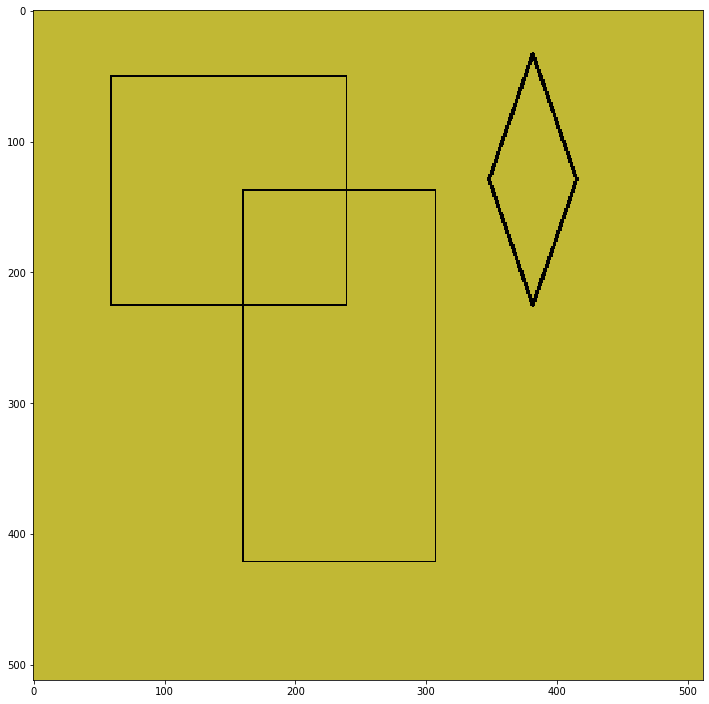

In [2]:
road = 'road.jpg'
test1 = 'test1.png'
raw_image = np.array(Image.open(test1)).astype(DTYPE)
gray_image = np.sum(raw_image * np.array([0.2125, 0.7154, 0.0721], dtype=DTYPE), -1)

imshow2(raw_image)

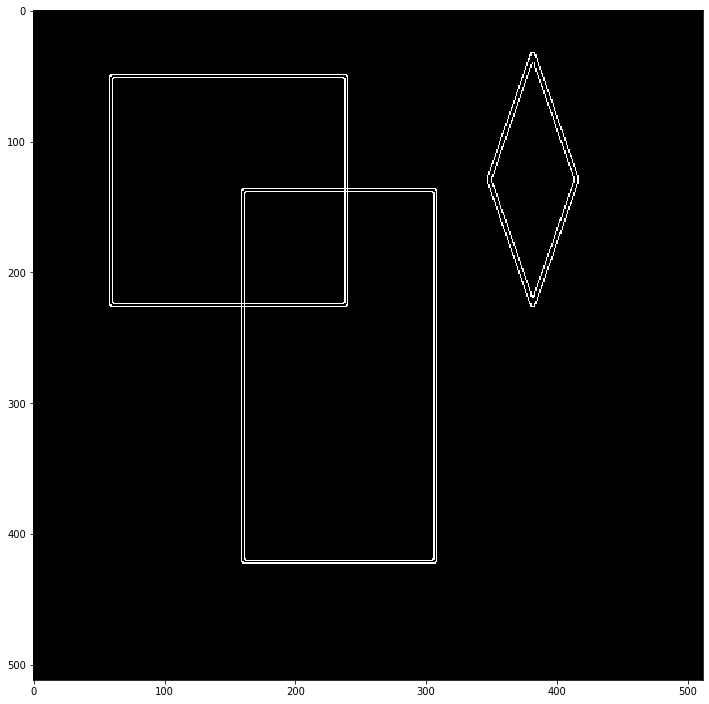

In [3]:
edges_mask = canny(gray_image, sigma=1)
imshow2(edges_mask)

In [4]:
y, x = np.nonzero(edges_mask)  
n_feature_points = len(x)

print(f'We got {n_feature_points} feature points, like:\n   x\ty'
      f'\n{np.stack([x, y], -1)[:10, :]}')

We got 3929 feature points, like:
   x	y
[[380  32]
 [381  32]
 [382  32]
 [383  32]
 [380  33]
 [383  33]
 [379  34]
 [380  34]
 [383  34]
 [384  34]]


In [5]:
n_thetas = 720
x = x[None, :]  # [N,] -> [1, N] 
y = y[None, :]  # [N,] -> [1, N]
thetas = np.linspace(-np.pi/2, np.pi/2, n_thetas)[:, None] # [M,] -> [M, 1]
print(f'thetas has shape {thetas.shape}, x has shape {x.shape}.')

thetas has shape (720, 1), x has shape (1, 3929).


In [6]:
# p = xcos(theta) + ysin(theta) 
hough_space = np.round(np.cos(thetas) @ x + np.sin(thetas) @ y)
hough_space = np.int64(hough_space)
print(f'`hough_space` has size: {hough_space.shape}'
      f', the minimum value in hough space is {np.min(hough_space)}')

`hough_space` has size: (720, 3929), the minimum value in hough space is -422


In [7]:
max_rho = np.ceil(np.hypot(*edges_mask.shape)).astype(np.intp)
print(f'edges_mask has shape: {edges_mask.shape}, max p is {max_rho}')

edges_mask has shape: (512, 512), max p is 725


In [8]:
hough_space += max_rho
print(f'the minimum value in hough space is {np.min(hough_space)}')

the minimum value in hough space is 303


time cost (loop) - 2.24s


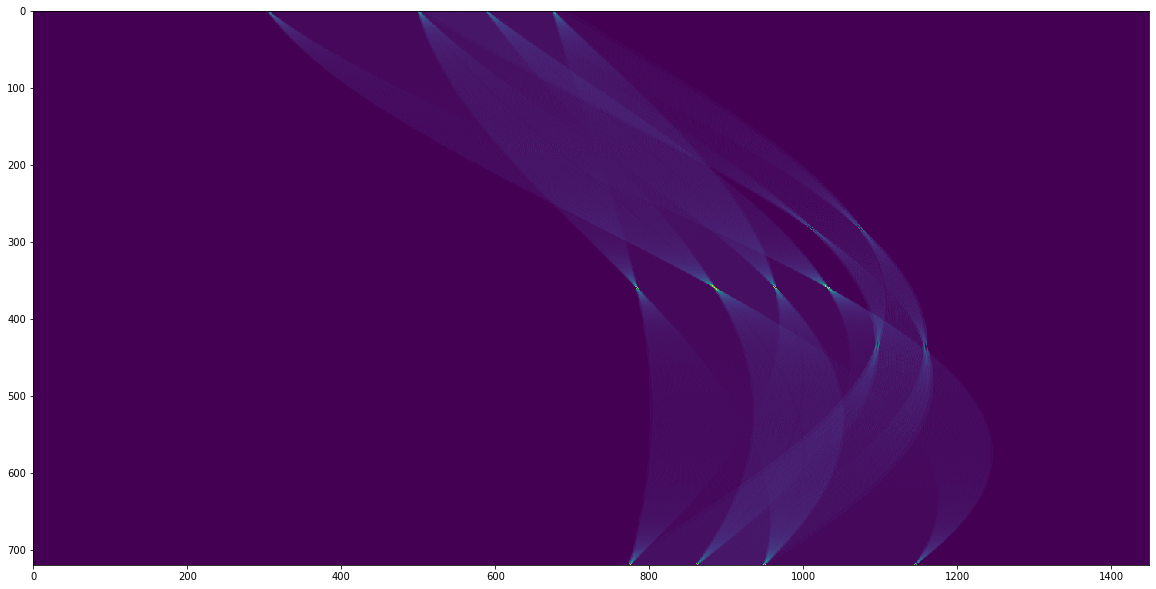

In [9]:
start_time = time()
accumulator = np.zeros((n_thetas, 2 * max_rho), dtype=np.int64)
for i in range(n_thetas):
    for j in range(n_feature_points):
        accumulator[i, hough_space[i, j]] += 1
print(f'time cost (loop) - {time() - start_time:.2f}s')

figure(figsize=[20, 20])
imshow(accumulator)
show()

time cost - 0.19s
x coordinate:
 [[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]] 

y coordinate:
 [[0 0 0]
 [1 1 1]
 [2 2 2]
 [3 3 3]
 [4 4 4]]

ravel y:
 [0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]


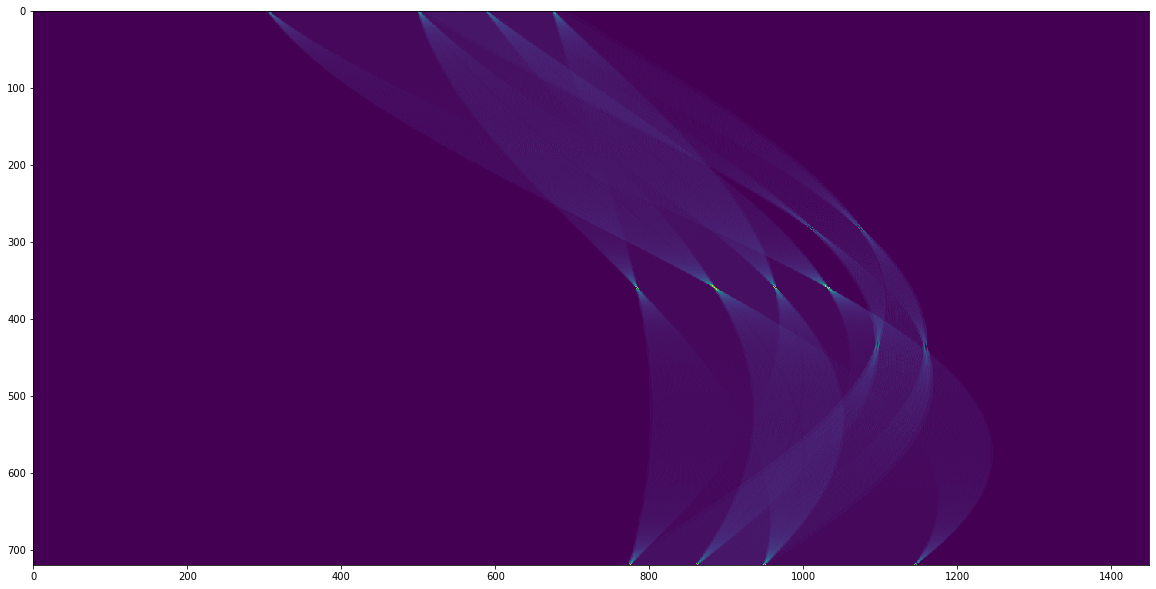

In [10]:
start_time = time()
theta_idx_bins = np.arange(-0.5, n_thetas + 0.5)
hough_space2_bins = np.arange(-0.5, max_rho * 2 + 0.5)
theta_idx = np.meshgrid(range(n_feature_points), range(n_thetas))[1].ravel()
hough_space2 = hough_space.ravel()
accumulator = np.histogram2d(theta_idx, hough_space2, bins=(theta_idx_bins, hough_space2_bins))[0]
print(f'time cost - {time() - start_time:.2f}s')

xx, yy = np.meshgrid(range(3), range(5))
print('x coordinate:\n', xx, '\n\ny coordinate:\n', yy)
print('\nravel y:\n', yy.ravel())
figure(figsize=[20, 20])
imshow(accumulator)
show()

In [11]:
index = np.argsort(accumulator.ravel())[::-1]
idx_of_theta, idx_of_rho = np.unravel_index(index, accumulator.shape)

rhos = np.linspace(-max_rho, max_rho, max_rho * 2)
rho = rhos[idx_of_rho]
theta = thetas[idx_of_theta]

print(f'The size of rho: {rho.shape}')

The size of rho: (1044000,)


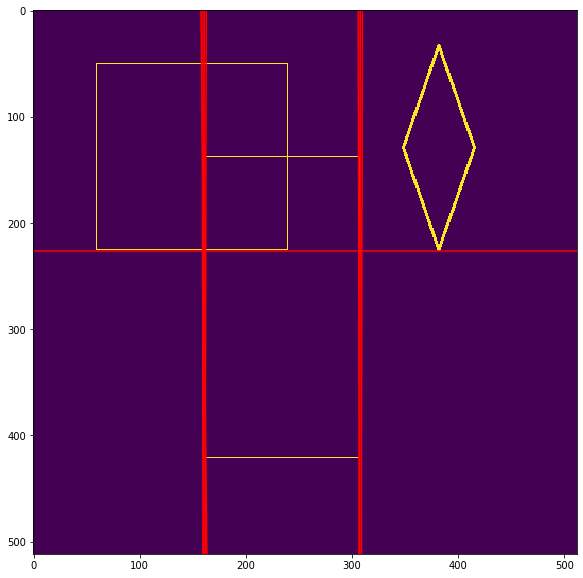

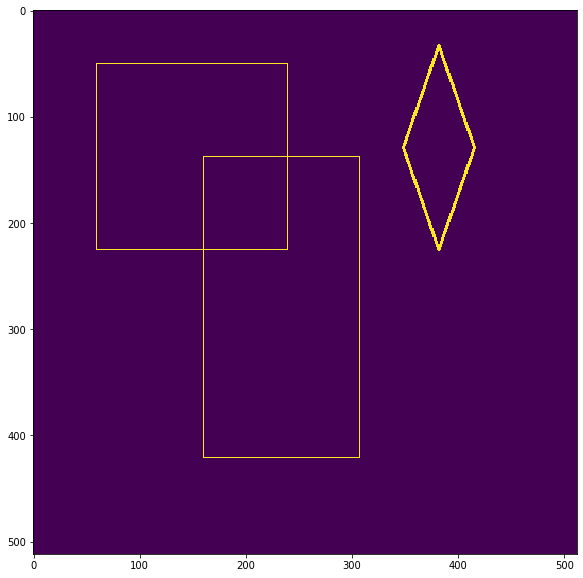

In [12]:
figure(figsize=[10, 10])
print()
for i in range(10):
    plot_line(theta[i], rho[i], image_shape=gray_image.shape)
imshow(gray_image)
figure(figsize=[10, 10])
imshow(gray_image)
show()